## Make multiwavelength light curves using archival data

### Summary:
 - model plots after van Velzen et al. 2021, https://arxiv.org/pdf/2111.09391.pdf
 
### Input:
 - a catalog of CLAGN from the literature

### Output:
 - an archival optical + IR + neutrino light curve
 
### Technical Goals:
 - should be able to run from a clean checkout from github
 - should be able to automatically download all catalogs & images used
 - need to have all photometry in the same physical unit
 - need to have a data structure that is easy to use but holds light curve information (time and units) and is extendable to ML applications
 - need to have a curated list of catalogs to search for photometry that is generalizeable to other input catalogs
 
### Authors:
IPAC SP team

### Acknowledgements:
Suvi Gezari, Antara Basu-zych,
MAST, HEASARC, & IRSA Fornax teams

In [199]:
import numpy as np
import time
import pandas as pd
import axs
import os
import sys
import re
import matplotlib.pyplot as plt
import json
import requests
import seaborn as sns

from astroquery.ipac.ned import Ned
from astroquery.heasarc import Heasarc
from astroquery.gaia import Gaia

from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, vstack, hstack, unique
from astropy.io import ascii


try: # Python 3.x
    from urllib.parse import quote as urlencode
    from urllib.request import urlretrieve
except ImportError:  # Python 2.x
    from urllib import pathname2url as urlencode
    from urllib import urlretrieve

try: # Python 3.x
    import http.client as httplib 
except ImportError:  # Python 2.x
    import httplib   

!pip install lightkurve --upgrade
import lightkurve as lk

!pip install ztfquery
from ztfquery import lightcurve

You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.


FileNotFoundError: [Errno 2] No such file or directory: './Data/skyvision'

## 1. Define the Sample

In [3]:
# use the following paper to make a sample of CLAGN: https://iopscience.iop.org/article/10.3847/1538-4357/aaca3a 

# This sample can later be switched out to a differen/larger sample of "interesting" targets

#use ADS to find the refcode for this paper
CLAGN = Ned.query_refcode('2018ApJ...862..109Y')



In [4]:
CLAGN

No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
int32,str30,float64,float64,object,float64,float64,object,object,float64,int32,int32,int32,int32,int32,int32,int32
1,WISEA J000107.52-000552.5,0.28136,-0.09789,G,59147.0,0.197292,SPEC,19.7g,--,6,0,34,8,5,4,0
2,WISEA J012648.10-083948.0,21.70037,-8.66335,G,59333.0,0.197913,SPEC,18.6g,--,22,0,62,14,8,8,0
3,2MASS J01595763+0033105,29.99,0.55301,QSO,93546.0,0.312036,SPEC,19.6g,--,63,0,76,17,19,10,0
4,WISEA J015957.63+003310.3,29.99015,0.55288,IrS,93547.0,0.31204,SLS,,--,4,0,12,3,2,0,0
5,WISEA J080347.56+425839.0,120.94815,42.97747,G,125547.0,0.418778,SPEC,21.8g,--,4,0,27,5,3,4,0
6,WISEA J083132.25+364617.0,127.88438,36.77146,G,58463.0,0.19501,SPEC,18.8g,--,17,0,62,9,7,10,0
7,WISEA J084957.78+274728.8,132.49077,27.79139,QSO,89499.0,0.298537,SPEC,19.1g,--,23,0,65,12,11,8,0
8,WISEA J090932.02+474730.7,137.38346,47.79186,G,35059.0,0.116944,SPEC,18.7g,--,19,0,53,8,6,8,1


### What is the best data structure for this work?
 - list of requirements is being kept here: https://github.com/fornax-navo/fornax-demo-notebooks/issues/69 
 - some things to keep an eye on as other people are actively working on this field
     - astropy has a light curve class
         -would require development work to make this work for multiwavelength application
     - LINCC people are interested in this and might have some suggestions on a 6mo. timescale
     - xarray
     - pandas pint has units support but also has a warning that it doesn't yet work perfectly
     - lightKurve is not suitable for this application
     - sunpy is also not suitable for this application

### Since there is nothing perfectly ready now, we need to go with something practical for the time being
 - instead of one large dataframe with the multiwavelength information, we could keep them as seperate astropy light curves for each band, do the feature extraction on each light curve and keep the features in one large dataframe. - how would we link targets between bands?
 - ZTF keeps the light curve info as multidimensional arrays in pandas columns - this works out of the box but doesn't have unit support so we just need to do that manually.

In [3]:
type(CLAGN)

astropy.table.table.Table

In [6]:
#### Build a list of skycoords from target ra and dec #####
coords_list = [
    SkyCoord(ra, dec, frame='icrs', unit='deg')
    for ra, dec in zip(CLAGN['RA'], CLAGN['DEC'])
]


## 2. Find light curves for these targets in NASA catalogs
- look at NAVO use cases to get help with tools to do this - although they mostly use pyvo
- deciding up front to use astroquery instead of pyvo
    - astroquery is apparently more user friendly
- data access concerns:
    - can't ask the archives to search their entire holdings
        - not good enough meta data
        - not clear that the data is all vetted and good enough to include for science
        - all catalogs have differently named columns so how would we know which columns to keep
    - instead work with a curated list of catalogs for each archive
        - focus on general surveys
        - try to ensure that this list is also appropriate for a generalization of this use case to other input catalogs
        - could astroquery.NED be useful in finding a generalized curated list
- How do we know we have a match that is good enough to include in our light curve
     - look at nway for the high energy catalogs
     - probably need to generate a table of search radii for each catalog based on bandpass
         - need domain knowledge for that
     


## 2.1 HEASARC: FERMI & Beppo SAX


In [41]:
mission_list = ['FERMIGTRIG', 'SAXGRBMGRB']
radius = 0.1*u.degree

for ccount, coord in enumerate(coords_list):
    #use astroquery to search that position for either a Fermi or Beppo Sax trigger
    for mcount, mission in enumerate(mission_list):
        try:
            results = heasarc.query_region(coord, mission = mission, radius = radius)#, sortvar = 'SEARCH_OFFSET_')
            print ("got a live one")
            #need to figure out what this result would look like and how to add that to the saved data structure
        except AttributeError:
            print("no results at that location for ", mission)


#**** These HEASARC searches are returning an attribute error because of an astroquery bug
# bug submitted to astroquery Oct 18, waiting for a fix.
# if that gets fixed, can probably change this cell 

no results at that location for  FERMIGTRIG
no results at that location for  SAXGRBMGRB
no results at that location for  FERMIGTRIG
no results at that location for  SAXGRBMGRB
no results at that location for  FERMIGTRIG
no results at that location for  SAXGRBMGRB
no results at that location for  FERMIGTRIG
no results at that location for  SAXGRBMGRB
no results at that location for  FERMIGTRIG
no results at that location for  SAXGRBMGRB
no results at that location for  FERMIGTRIG
no results at that location for  SAXGRBMGRB
no results at that location for  FERMIGTRIG
no results at that location for  SAXGRBMGRB
no results at that location for  FERMIGTRIG
no results at that location for  SAXGRBMGRB
no results at that location for  FERMIGTRIG
no results at that location for  SAXGRBMGRB
no results at that location for  FERMIGTRIG
no results at that location for  SAXGRBMGRB
no results at that location for  FERMIGTRIG
no results at that location for  SAXGRBMGRB
no results at that location for 

## 2.2 IRSA: ZTF

In [8]:
#python package ztfquery is not a good solution for this because it requires IRSA password
#Instead will construct the URL for an API query
#https://irsa.ipac.caltech.edu/docs/program_interface/ztf_lightcurve_api.html
ztf_radius = 0.000278   #as suggested by Dave Shupe

for ccount, coord in enumerate(coords_list):
    #doesn't take SkyCoord
    ra = CLAGN['RA'][ccount]
    dec = CLAGN['DEC'][ccount]
    #make the string for the URL query
    #ask for all three bands (g, r, i)
    #don't want data that is flagged as unusable by the ZTF pipeline
    urlstr = 'https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE %f %f %f&BANDNAME=g,r,i&FORMAT=ipac_table&BAD_CATFLAGS_MASK=32768'%(ra, dec,ztf_radius)

    response = requests.get(urlstr)
    if response.ok:
        ztf_lc = ascii.read(response.text, format='ipac')
        #print(count, len(ztf_lc))
        #this could be up to 3 light curves because there are 3 filters
        #need to sort by filtercode 'zg','zr','zi'
        #and store the light curves
    else:
        print(ccount, " There is no ZTF light curve at this position")

0 0.28136 -0.09789


KeyboardInterrupt: 

## 2.3 IRSA:WISE

- Dave Shupe has made a catalog of neowise light curves of half the sky in a parquet file

- Pandas is not a good option for working with this catalog because it is so large (2 billion rows?)

- Instead we can use AXS to cross match the CLAGN sample with the neowise catalog to find those rows in neowise which correspond to the CLAGN sample. AXS is a part of spark. 


In [12]:
#%%time
#could load the neowise light curves into pandas, but would need to severely
# filter the catalog to get it to fit into memory.  Since these targets are all over the sky
# it is not obvious how to filter the catalog

#Here is one way it could work in Pandas if we had a way to filter significantly before matching
#subset = pd.read_parquet('/stage/irsa-data-download10/parquet-work/NEOWISE-R/neowise_lc_half.parquet',
#                    engine='pyarrow', 
#                    filters=[ ('ra', '<', 121) , ('ra', '>', 120) , 
#                            ('dec', '<', 68) , ('dec', '>', -9),
#                            ('cw_w1mpro', '>', 15.0) ])
#
#len(subset)

CPU times: user 1h 53min 48s, sys: 4h 16min 37s, total: 6h 10min 25s
Wall time: 23min 46s


In [24]:
#start up SPARK
os.environ['SPARK_CONF_DIR'] = '/home/jkrick/axs_store/conf_alt'

def spark_start(work_dir, database_dir, warehouse_dir):
    from pyspark.sql import SparkSession
    import os
    
    spark = (
            SparkSession.builder
            .appName("spark trial")
            .config("spark.sql.warehouse.dir", warehouse_dir)
            .config('spark.master', "local[20]")
            .config('spark.driver.memory', '64G') # 128
            .config('spark.executor.memory', '30G')
            .config('spark.local.dir', work_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '128G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "60G")
            .config("spark.driver.extraJavaOptions", 
                    f"-Dderby.system.home={database_dir}")
            .config("spark.sql.hive.metastore.sharedPrefixes",
                    "org.apache.derby")
            .enableHiveSupport()
            .getOrCreate()
                    )   

    return spark

spark_session = spark_start(
    "/stage/irsa-staff-jkrick/spark_work",
    "/home/jkrick/axs_store",
    "/stage/irsa-staff-jkrick/sp_axs_warehouse/warehouse")

In [25]:
#if the one we want is not yet available, add it to the list
catalog = axs.AxsCatalog(spark_session)
catlist = catalog.list_table_names()

if 'neowise_lc_half' not in catlist:
    catalog.import_existing_table('neowise_lc_half', 
        '/stage/irsa-data-download10/parquet-work/NEOWISE-R/neowise_lc_half.parquet',
        import_into_spark=True)
    

#now figure out how to get the CLAGN catalog into AXS
#can't go direct from astropy table into AXS, so first to pandas

if 'axs_clagn' not in catlist:

    pd_CLAGN = CLAGN.to_pandas()

    #then pandas to spark dataframe
    sp_CLAGN = spark_session.createDataFrame(pd_CLAGN)

    #ok, saving below can't handle capital "RA" and "DEC", so need to change that
    #also can't handle column names with spaces in them so need to rename those as well.
    sp_CLAGN2 = sp_CLAGN.withColumnRenamed("RA","ra").withColumnRenamed("DEC","dec").withColumnRenamed("Object Name", "Object_name").withColumnRenamed("Redshift Flag","redshift_flag").withColumnRenamed("Magnitude and Filter", "magnitude_and_filter").withColumnRenamed("Photometry Points","photometry_points").withColumnRenamed("Redshift Points", "redshift_points").withColumnRenamed("Diameter Points","diameter_points")

    #now save spark to AXS
    catalog.save_axs_table(sp_CLAGN2, 'AXS_CLAGN', calculate_zone=True)

In [28]:
#just confirm that worked:
#catalog = axs.AxsCatalog(spark_session)
#catlist = catalog.list_table_names()
#catlist

['gaia_edr3', 'catwise_corrected', 'neowise_lc_half', 'axs_clagn']

In [29]:
#lazy load in the NEOWISE and CLAGN catalog
neowise_lc_half = catalog.load('neowise_lc_half')
axs_clagn = catalog.load('axs_clagn')

#rename column name which is causing problems
axs_clagn = axs_clagn.withColumnRenamed("No.", "objnum")

In [50]:
#crossmatch CLAGN with NEOWISE

neowise_CLAGN = neowise_lc_half.crossmatch(axs_clagn, 2*axs.Constants.ONE_ASEC, return_min = True, include_dist_col = True)


In [51]:
%%time
#lazy evaluation means the cross match won't happen until this cell gets executed
#how many matches did we get?
neowise_CLAGN.count()

CPU times: user 29.5 ms, sys: 16.8 ms, total: 46.4 ms
Wall time: 2min 7s


29

In [53]:
%%time
#now get it into a format that I can handle
#this is taking a long time 45min? for 29 rows? for all columns
#more like 18 min for limited set of columns

#make a smaller version with just the light curve info to save
neowise_lc = neowise_CLAGN.select('objnum','Object_name','w1pmag','w1pmagerr','w2pmag','w2pmagerr', 'mjd')

#convert to Pandas dataframe
pd_neowise_lc = neowise_lc.toPandas()

#instead maybe try parquet?  csv doesn't work since there are arrays in the columns
#neowise_CLAGN.write.parquet("neowise_CLAGN.parquet")

#instead try pulling the data into a pandas dataframe
#is this faster? no 1h 58 min. for all columns
#pd_neowise_CLAGN = pd.DataFrame.from_records(neowise_CLAGN.collect(), columns=neowise_CLAGN.columns)

In [186]:
#need to convert those magnitudes into flux to be consistent in data structure.
#go to Janskies
#using zeropoints from here: https://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html
def convert_WISEtoJanskies(mag, magerr, band):
    if band == 'w1':
        zpt = 309.54
    elif band == 'w2':
        zpt = 171.787
            
    flux_Jy = zpt*(10**(-mag/2.5))
    
    #calculate the error
    magupper = mag + magerr
    maglower = mag - magerr
    flux_upper = abs(flux - (zpt*(10**(-magupper/2.5))))
    flux_lower = abs(flux - (zpt*(10**(-maglower/2.5))))
    
    fluxerr_Jy = (flux_upper + flux_lower) / 2.0
    
    return flux_Jy, fluxerr_Jy

In [130]:
def convert_decimal_float(changetype):

    #columns which are themselves arrays
    changetype['mjd'] = [changetype.mjd[i].astype(float) for i in range(len(changetype))]
    changetype['w1mag'] = [changetype.w1pmag[i].astype(float) for i in range(len(changetype))]
    changetype['w2mag'] = [changetype.w2pmag[i].astype(float) for i in range(len(changetype))]
    changetype['w1error'] = [changetype.w1pmagerr[i].astype(float) for i in range(len(changetype))]
    changetype['w2error'] = [changetype.w2pmagerr[i].astype(float) for i in range(len(changetype))]

    return changetype


In [131]:
#decimals are causing problems when trying to do things with these columns, aka, convert units
floats = convert_decimal_float(pd_neowise_lc)

In [182]:
for i in range(29):
    print(i, floats['w2mag'][i].size, floats['w2error'][i].size)

0 124 111
1 181 181
2 128 128
3 186 180
4 108 108
5 152 152
6 31 26
7 104 69
8 109 109
9 96 96
10 96 96
11 97 96
12 88 74
13 105 105
14 237 236
15 150 150
16 155 155
17 70 55
18 75 44
19 112 112
20 107 102
21 72 33
22 138 138
23 193 193
24 237 237
25 138 130
26 101 101
27 116 116
28 99 95


In [184]:
##ack, errors don't have same lengths as flux arrays!!
#well, we need to exclude w2 for now and figure this out

(array([15.119, 14.817, 14.662, 14.622, 14.723, 14.947, 14.641, 14.618,
        14.743, 14.927, 14.769, 14.634, 14.631, 14.858, 14.702, 14.656,
        14.667, 15.287, 14.785, 14.979, 15.347, 15.265, 15.183, 14.976,
        15.045, 15.156, 14.968, 14.717, 14.352, 14.604, 14.389]),
 array([0.382, 0.283, 0.273, 0.264, 0.351, 0.447, 0.243, 0.3  , 0.349,
        0.309, 0.298, 0.373, 0.271, 0.275, 0.313, 0.461, 0.408, 0.425,
        0.388, 0.409, 0.417, 0.471, 0.417, 0.389, 0.434, 0.296]))

In [187]:
#pd_neowise_lc.drop(columns = ['w1flux', 'w1fluxerr'], inplace = True)

#make new columns with fluxes instead of magnitudes for comparison with other bands
w1flux, w1fluxerr = convert_WISEtoJanskies(floats['w1mag'],floats['w1error'] ,'w1')
flux_lc = pd_neowise_lc.assign(w1flux = w1flux, w1fluxerr = w1fluxerr)

#w2flux, w2fluxerr = convert_WISEtoJanskies(floats['w2mag'],floats['w2error'] ,'w2')
#flux_lc = flux_lc.assign(w2flux = w2flux, w2fluxerr = w2fluxerr)


In [188]:
flux_lc

,objnum,Object_name,w1pmag,w1pmagerr,w2pmag,w2pmagerr,mjd,w1mag,w2mag,w1error,w2error,w1flux,w1fluxerr
0,19,WISEA J115039.31+363258.3,"[14.972, 14.980, 15.193, 15.011, 15.203, 15.14...","[0.092, 0.091, 0.114, 0.091, 0.105, 0.115, 0.1...","[14.443, 14.711, 14.428, 14.357, 14.692, 14.34...","[0.234, 0.277, 0.184, 0.187, 0.328, 0.175, 0.2...","[56806.23584315, 56806.36738292, 56806.4990501...","[14.972, 14.98, 15.193, 15.011, 15.203, 15.149...","[14.443, 14.711, 14.428, 14.357, 14.692, 14.34...","[0.092, 0.091, 0.114, 0.091, 0.105, 0.115, 0.1...","[0.234, 0.277, 0.184, 0.187, 0.328, 0.175, 0.2...","[0.0003176265360019476, 0.0003152947782582714,...","[2.694634526420931e-05, 2.6457097865076822e-05..."
1,21,WISEA J125916.74+551507.1,"[14.249, 13.946, 14.276, 13.924, 14.158, 13.83...","[0.056, 0.047, 0.061, 0.055, 0.054, 0.047, 0.0...","[13.914, 13.294, 13.820, 13.295, 13.590, 13.38...","[0.147, 0.077, 0.143, 0.085, 0.112, 0.089, 0.1...","[58819.78255547, 56805.18709016, 58819.9133315...","[14.249, 13.946, 14.276, 13.924, 14.158, 13.83...","[13.914, 13.294, 13.82, 13.295, 13.59, 13.38, ...","[0.056, 0.047, 0.061, 0.055, 0.054, 0.047, 0.0...","[0.147, 0.077, 0.143, 0.085, 0.112, 0.089, 0.1...","[0.0006181826020703642, 0.0008171782110804874,...","[3.189870305248091e-05, 3.538554960067354e-05,..."
2,11,WISEA J100323.46+352503.8,"[13.691, 13.848, 13.589, 13.744, 13.694, 13.80...","[0.040, 0.047, 0.041, 0.040, 0.048, 0.047, 0.0...","[13.076, 12.985, 13.020, 12.857, 12.876, 13.20...","[0.079, 0.077, 0.079, 0.069, 0.060, 0.093, 0.0...","[56783.33390462, 56974.31748493, 56783.4655721...","[13.691, 13.848, 13.589, 13.744, 13.694, 13.80...","[13.076, 12.985, 13.02, 12.857, 12.876, 13.207...","[0.04, 0.047, 0.041, 0.04, 0.048, 0.047, 0.037...","[0.079, 0.077, 0.079, 0.069, 0.06, 0.093, 0.07...","[0.001033514985914946, 0.0008943690837517979, ...","[3.8084713142681704e-05, 3.872807809273689e-05..."
3,24,WISEA J135855.82+493414.0,"[14.913, 15.034, 14.961, 15.153, 15.027, 15.32...","[0.116, 0.142, 0.161, 0.112, 0.143, 0.125, 0.1...","[14.230, 13.990, 14.256, 14.284, 14.641, 14.22...","[0.168, 0.148, 0.187, 0.195, 0.261, 0.162, 0.1...","[56649.00681251, 56651.57662406, 56651.6424578...","[14.913, 15.034, 14.961, 15.153, 15.027, 15.32...","[14.23, 13.99, 14.256, 14.284, 14.641, 14.222,...","[0.116, 0.142, 0.161, 0.112, 0.143, 0.125, 0.1...","[0.168, 0.148, 0.187, 0.195, 0.261, 0.162, 0.1...","[0.00033536426044995386, 0.0002999969077850443...","[3.589850496852628e-05, 3.934759683451084e-05,..."
4,23,WISEA J135618.50-011514.0,"[14.346, 14.443, 14.448, 14.409, 14.761, 14.49...","[0.067, 0.068, 0.069, 0.073, 0.098, 0.071, 0.0...","[13.719, 13.585, 13.693, 13.546, 13.472, 13.65...","[0.158, 0.111, 0.145, 0.115, 0.166, 0.137, 0.1...","[56675.96289389, 56675.96302126, 56676.0946888...","[14.346, 14.443, 14.448, 14.409, 14.761, 14.49...","[13.719, 13.585, 13.693, 13.546, 13.472, 13.65...","[0.067, 0.068, 0.069, 0.073, 0.098, 0.071, 0.0...","[0.158, 0.111, 0.145, 0.115, 0.166, 0.137, 0.1...","[0.0005653491951856132, 0.0005170312322387887,...","[3.490943828463988e-05, 3.240300277340612e-05,..."
5,27,WISEA J154529.63+251127.9,"[13.172, 13.194, 13.162, 13.153, 13.064, 13.22...","[0.032, 0.031, 0.030, 0.029, 0.033, 0.032, 0.0...","[12.507, 12.559, 12.516, 12.451, 12.490, 12.47...","[0.050, 0.063, 0.052, 0.048, 0.062, 0.044, 0.0...","[56695.06130823, 56695.19297569, 56695.3247705...","[13.172, 13.194, 13.162, 13.153, 13.064, 13.22...","[12.507, 12.559, 12.516, 12.451, 12.49, 12.476...","[0.032, 0.031, 0.03, 0.029, 0.033, 0.032, 0.03...","[0.05, 0.063, 0.052, 0.048, 0.062, 0.044, 0.04...","[0.0016669277566711462, 0.0016334911213347972,...","[4.913662358634475e-05, 4.664586575840854e-05,..."
6,10,WISEA J093735.45+323250.6,"[15.435, 15.555, 15.487, 15.742, 15.639, 15.71...","[0.144, 0.170, 0.143, 0.182, 0.176, 0.179, 0.1...","[15.119, 14.817, 14.662, 14.622, 14.723, 14.94...","[0.382, 0.283, 0.273, 0.264, 0.351, 0.447, 0.2...","[56779.84509649, 56779.97663669, 56780.

In [189]:
del df_lc

In [191]:
#syntax isn't working and getting data type errors to convert the whole dataframe of arrays 
#into the multiindex dataframe structure for saving
#instead try iterating over rows in df and filling dfsingle from there.
#this is a crazy inefficiency, but....
pd_neowise_lc.reset_index()
for index, row in flux_lc.iterrows():
    dfw1 = pd.DataFrame(dict(flux=row.w1flux, err=row.w1fluxerr, time=row.mjd, objectid=row.objnum, band='w1')).set_index(["objectid", "band", "time"])

    #then concatenate each individual df together
    #first make sure that df has been defined before
    try:
        df_lc
    except NameError:
        #df_lc doesn't exist (yet)
        df_lc = dfw1
    else:
        #df_lc exists
        df_lc = pd.concat([df_lc, dfw1])#, dfw2])


## 2.4 MAST: Pan-STARRS
Code ideas taken from this website: https://ps1images.stsci.edu/ps1_dr2_api.html

In [9]:
def ps1cone(ra,dec,radius,table="mean",release="dr1",format="csv",columns=None,
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs", verbose=False,
           **kw):
    """Do a cone search of the PS1 catalog
    
    Parameters
    ----------
    ra (float): (degrees) J2000 Right Ascension
    dec (float): (degrees) J2000 Declination
    radius (float): (degrees) Search radius (<= 0.5 degrees)
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'nDetections.min':2)
    """
    
    data = kw.copy()
    data['ra'] = ra
    data['dec'] = dec
    data['radius'] = radius
    return ps1search(table=table,release=release,format=format,columns=columns,
                    baseurl=baseurl, verbose=verbose, **data)


def ps1search(table="mean",release="dr1",format="csv",columns=None,
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs", verbose=False,
           **kw):
    """Do a general search of the PS1 catalog (possibly without ra/dec/radius)
    
    Parameters
    ----------
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'nDetections.min':2).  Note this is required!
    """
    
    data = kw.copy()
    if not data:
        raise ValueError("You must specify some parameters for search")
    checklegal(table,release)
    if format not in ("csv","votable","json"):
        raise ValueError("Bad value for format")
    url = f"{baseurl}/{release}/{table}.{format}"
    if columns:
        # check that column values are legal
        # create a dictionary to speed this up
        dcols = {}
        for col in ps1metadata(table,release)['name']:
            dcols[col.lower()] = 1
        badcols = []
        for col in columns:
            if col.lower().strip() not in dcols:
                badcols.append(col)
        if badcols:
            raise ValueError('Some columns not found in table: {}'.format(', '.join(badcols)))
        # two different ways to specify a list of column values in the API
        # data['columns'] = columns
        data['columns'] = '[{}]'.format(','.join(columns))

# either get or post works
#    r = requests.post(url, data=data)
    r = requests.get(url, params=data)

    if verbose:
        print(r.url)
    r.raise_for_status()
    if format == "json":
        return r.json()
    else:
        return r.text


def checklegal(table,release):
    """Checks if this combination of table and release is acceptable
    
    Raises a VelueError exception if there is problem
    """
    
    releaselist = ("dr1", "dr2")
    if release not in ("dr1","dr2"):
        raise ValueError("Bad value for release (must be one of {})".format(', '.join(releaselist)))
    if release=="dr1":
        tablelist = ("mean", "stack")
    else:
        tablelist = ("mean", "stack", "detection")
    if table not in tablelist:
        raise ValueError("Bad value for table (for {} must be one of {})".format(release, ", ".join(tablelist)))


def ps1metadata(table="mean",release="dr1",
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs"):
    """Return metadata for the specified catalog and table
    
    Parameters
    ----------
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    baseurl: base URL for the request
    
    Returns an astropy table with columns name, type, description
    """
    
    checklegal(table,release)
    url = f"{baseurl}/{release}/{table}/metadata"
    r = requests.get(url)
    r.raise_for_status()
    v = r.json()
    # convert to astropy table
    tab = Table(rows=[(x['name'],x['type'],x['description']) for x in v],
               names=('name','type','description'))
    return tab


def addfilter(dtab):
    """Add filter name as column in detection table by translating filterID
    
    This modifies the table in place.  If the 'filter' column already exists,
    the table is returned unchanged.
    """
    if 'filter' not in dtab.colnames:
        # the filterID value goes from 1 to 5 for grizy
        id2filter = np.array(list('grizy'))
        dtab['filter'] = id2filter[(dtab['filterID']-1).data]
    return dtab


In [192]:
#try for panstarrs
radius = 1.0/3600.0 # radius = 1 arcsec
plt.rcParams.update({'font.size': 14})
plt.figure(1,(10,10))

        
#for all objects
for ccount, coord in enumerate(coords_list):
    #doesn't take SkyCoord
    ra = CLAGN['RA'][ccount]
    dec = CLAGN['DEC'][ccount]

    #see if there is an object in panSTARRS at this location
    results = ps1cone(ra,dec,radius,release='dr2')
    tab = ascii.read(results)
    
    # improve the format
    for filter in 'grizy':
        col = filter+'MeanPSFMag'
        tab[col].format = ".4f"
        tab[col][tab[col] == -999.0] = np.nan
        
    #in case there is more than one object within 1 arcsec, sort them by match distance
    tab.sort('distance')
    
    #if there is an object at that location
    if len(tab) > 0:   
        #got a live one
        #print( 'for object', ccount + 1, 'there is ',len(tab), 'match in panSTARRS', tab['objID'])

        #take the closest match as the best match
        objid = tab['objID'][0]
        
        #setup to pull light curve info
        dconstraints = {'objID': objid}
        dcolumns = ("""objID,detectID,filterID,obsTime,ra,dec,psfFlux,psfFluxErr,psfMajorFWHM,psfMinorFWHM,
                    psfQfPerfect,apFlux,apFluxErr,infoFlag,infoFlag2,infoFlag3""").split(',')
        # strip blanks and weed out blank and commented-out values
        dcolumns = [x.strip() for x in dcolumns]
        dcolumns = [x for x in dcolumns if x and not x.startswith('#')]


        #get the actual detections and light curve info for this target
        dresults = ps1search(table='detection',release='dr2',columns=dcolumns,**dconstraints)
        
        #sometimes there isn't actually a light curve for the target???
        try:
            ascii.read(dresults)
        except FileNotFoundError:
            print("There is no light curve")
            #no need to store PanSTARRS data for this one
        else:
            #There is a light curve for this target
            
            #fix the column names to include filter names
            dtab = addfilter(ascii.read(dresults))
            dtab.sort('obsTime')

            #here is the light curve mixed from all 5 bands
            t_panstarrs = dtab['obsTime']
            flux_panstarrs = dtab['psfFlux']  # in Jy
            err_panstarrs = dtab['psfFluxErr']
            filtername = dtab['filter']
            
            #put this single object light curves into a pandas multiindex dataframe
            dfsingle = pd.DataFrame(dict(flux=flux_panstarrs, err=err_panstarrs, time=t_panstarrs, objectid=ccount + 1, band=filtername)).set_index(["objectid", "band", "time"])
            
            #then concatenate each individual df together
            #first make sure that df has been defined before
            try:
                df_lc
            except NameError:
                #df_lc doesn't exist (yet)
                df_lc = dfsingle
            else:
                #df_lc exists
                df_lc = pd.concat([df_lc, dfsingle])
                
            
            #plot light curves on same plot just to know they are there?
            #not currently working
            #xlim = np.array([t.min(),t.max()])
            #xlim = xlim + np.array([-1,1])*0.02*(xlim[1]-xlim[0])
            #for i, filter in enumerate("grizy"):
            #    plt.subplot(511+i)
            #    w = np.where(dtab['filter']==filter)
            #    plt.plot(t[w],flux[w],'-o')
            #    plt.ylabel(filter+' [Jy]')
            #    plt.xlim(xlim)
            #    #plt.gca().invert_yaxis()
            #    if i==0:
            #        plt.title(objid)
            #plt.xlabel('Time [MJD]')
            #plt.tight_layout()

<Figure size 720x720 with 0 Axes>

In [193]:
#pd.set_option('display.max_rows',None)
df_lc
#pd.reset_option('all')

flux       err
objectid band time                            
19       w1   56806.235843  0.000318  0.000027
              56806.367383  0.000315  0.000026
              56806.499050  0.000259  0.000027
              56806.630590  0.000306  0.000026
              56806.696423  0.000257  0.000025
...                              ...       ...
31       y    56868.625712  0.000094  0.000010
         i    56912.473952  0.000056  0.000002
              56912.485421  0.000057  0.000002
              56912.496921  0.000060  0.000002
              56912.508399  0.000060  0.000002

[5762 rows x 2 columns]

## 2.5 MAST: ATLAS all-sky stellar reference catalog (g, r, i) < 19mag
 -  MAST has this catalog but it is not clear that it has the individual epoch photometry and it is only accessible with casjobs, not through python notebooks.  

 https://archive.stsci.edu/hlsp/atlas-refcat2#section-a737bc3e-2d56-4827-9ab4-838fbf8d67c1
 
 - if we really want to pursue this, we can put in a MAST helpdesk ticket to see if a) they do have the light curves, and b) they could switch the catalog to a searchable with python version.  There are some ways of accessing casjobs through python (<https://github.com/spacetelescope/notebooks/blob/master/notebooks/MAST/HSC/HCV_CASJOBS/HCV_casjobs_demo.ipynb), but apparently not this particular catalog.  
 

## 2.6 MAST: TESS, Kepler and K2
 - use lightKurve to search all 3

In [5]:
radius = 1.0  #arcseconds

#for all objects
for count, coord in enumerate(coords_list):
    print("working on object", count, coord)
    
    #use lightkurve to search TESS, Kepler and K2
    search_result = lk.search_lightcurve(coord, radius = radius)
    
    #figure out what to do with the results
    if len(search_result) < 1:
        #there is no data in these missions at this location
    else:
        #don't know what this looks like because none of these targets has a light curve
        #https://docs.lightkurve.org/tutorials/1-getting-started/searching-for-data-products.html
        #has a tutorial on how to do this
        #might look something like this:
        #lc_collection = search_result[*].download_all()


working on object 0 <SkyCoord (ICRS): (ra, dec) in deg
    (0.28136, -0.09789)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.28136, -0.09789)>".


0
working on object 1 <SkyCoord (ICRS): (ra, dec) in deg
    (21.70037, -8.66335)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (21.70037, -8.66335)>".


0
working on object 2 <SkyCoord (ICRS): (ra, dec) in deg
    (29.99, 0.55301)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.99, 0.55301)>".


0
working on object 3 <SkyCoord (ICRS): (ra, dec) in deg
    (29.99015, 0.55288)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.99015, 0.55288)>".


0
working on object 4 <SkyCoord (ICRS): (ra, dec) in deg
    (120.94815, 42.97747)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (120.94815, 42.97747)>".


0
working on object 5 <SkyCoord (ICRS): (ra, dec) in deg
    (127.88438, 36.77146)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (127.88438, 36.77146)>".


0
working on object 6 <SkyCoord (ICRS): (ra, dec) in deg
    (132.49077, 27.79139)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (132.49077, 27.79139)>".


0
working on object 7 <SkyCoord (ICRS): (ra, dec) in deg
    (137.38346, 47.79186)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (137.38346, 47.79186)>".


0
working on object 8 <SkyCoord (ICRS): (ra, dec) in deg
    (144.37635, 26.04226)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (144.37635, 26.04226)>".


0
working on object 9 <SkyCoord (ICRS): (ra, dec) in deg
    (144.39777, 32.5472)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (144.39777, 32.5472)>".


0
working on object 10 <SkyCoord (ICRS): (ra, dec) in deg
    (150.84777, 35.41774)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (150.84777, 35.41774)>".


0
working on object 11 <SkyCoord (ICRS): (ra, dec) in deg
    (152.97077, 54.7018)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (152.97077, 54.7018)>".


0
working on object 12 <SkyCoord (ICRS): (ra, dec) in deg
    (166.09674, 63.71816)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (166.09674, 63.71816)>".


0
working on object 13 <SkyCoord (ICRS): (ra, dec) in deg
    (166.22989, 1.31573)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (166.22989, 1.31573)>".


0
working on object 14 <SkyCoord (ICRS): (ra, dec) in deg
    (167.60602, -0.05948)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (167.60602, -0.05948)>".


0
working on object 15 <SkyCoord (ICRS): (ra, dec) in deg
    (168.90238, 5.74715)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (168.90238, 5.74715)>".


0
working on object 16 <SkyCoord (ICRS): (ra, dec) in deg
    (169.62351, 32.06666)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (169.62351, 32.06666)>".


0
working on object 17 <SkyCoord (ICRS): (ra, dec) in deg
    (173.12142, 3.95808)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (173.12142, 3.95808)>".


0
working on object 18 <SkyCoord (ICRS): (ra, dec) in deg
    (177.66385, 36.54956)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (177.66385, 36.54956)>".


0
working on object 19 <SkyCoord (ICRS): (ra, dec) in deg
    (178.11465, 32.16646)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (178.11465, 32.16646)>".


0
working on object 20 <SkyCoord (ICRS): (ra, dec) in deg
    (194.81978, 55.25199)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (194.81978, 55.25199)>".


0
working on object 21 <SkyCoord (ICRS): (ra, dec) in deg
    (199.87808, 67.89872)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (199.87808, 67.89872)>".


0
working on object 22 <SkyCoord (ICRS): (ra, dec) in deg
    (209.07707, -1.2539)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (209.07707, -1.2539)>".


0
working on object 23 <SkyCoord (ICRS): (ra, dec) in deg
    (209.73263, 49.5706)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (209.73263, 49.5706)>".


0
working on object 24 <SkyCoord (ICRS): (ra, dec) in deg
    (221.97599, 28.55669)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (221.97599, 28.55669)>".


0
working on object 25 <SkyCoord (ICRS): (ra, dec) in deg
    (233.48331, 1.17494)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (233.48331, 1.17494)>".


0
working on object 26 <SkyCoord (ICRS): (ra, dec) in deg
    (236.3735, 25.19107)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (236.3735, 25.19107)>".


0
working on object 27 <SkyCoord (ICRS): (ra, dec) in deg
    (237.57179, 41.65064)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (237.57179, 41.65064)>".


0
working on object 28 <SkyCoord (ICRS): (ra, dec) in deg
    (238.24292, 27.62456)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (238.24292, 27.62456)>".


0
working on object 29 <SkyCoord (ICRS): (ra, dec) in deg
    (238.66774, 36.4978)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (238.66774, 36.4978)>".


0
working on object 30 <SkyCoord (ICRS): (ra, dec) in deg
    (354.01242, 0.29132)>


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (354.01242, 0.29132)>".


0


## 2.6 MAST: HCV
 - hubble catalog of variables (https://archive.stsci.edu/hlsp/hcv)
 - follow notebook here to know how to search and download light curves https://archive.stsci.edu/hst/hsc/help/HCV/HCV_API_demo.html

## 3. Find light curves for these targets in relevant, non-NASA catalogs


### Gaia (Faisst)
- astroquery.gaia will presumably work out of the box for this

In [12]:
############ EXTRACT GAIA DATA FOR OBJECTS ##########

## Select Gaia table (DR3)
Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source"

## Define search radius
radius = u.Quantity(20, u.arcsec)

## Search and Cross match.
# This can be done in a smarter way by matching catalogs on the Gaia server, or grouping the
# sources and search a larger area.

# get catalog
gaia_table = Table()
t1 = time.time()
for cc,coord in enumerate(coords_list):
    print(len(coords_list)-cc , end=" ")

    gaia_search = Gaia.cone_search_async(coordinate=coord, radius=radius , background=True)
    gaia_search.get_data()["dist"].unit = "deg"
    gaia_search.get_data()["dist"] = gaia_search.get_data()["dist"].to(u.arcsec) # Change distance unit from degrees to arcseconds
    
    
    # match
    if len(gaia_search.get_data()["dist"]) > 0:
        gaia_search.get_data()["input_object_name"] = CLAGN["Object Name"][cc] # add input object name to catalog
        sel_min = np.where( (gaia_search.get_data()["dist"] < 1*u.arcsec) & (gaia_search.get_data()["dist"] == np.nanmin(gaia_search.get_data()["dist"]) ) )[0]
    else:
        sel_min = []
        
    #print("Number of sources matched: {}".format(len(sel_min)) )
    
    if len(sel_min) > 0:
        gaia_table = vstack( [gaia_table , gaia_search.get_data()[sel_min]] )
    else:
        gaia_table = vstack( [gaia_table , gaia_search.get_data()[sel_min]] )

print("\nSearch completed in {:.2f} seconds".format((time.time()-t1) ) )
print("Number of objects mached: {} out of {}.".format(len(gaia_table),len(CLAGN) ) )

31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 
Search completed in 79.36 seconds
Number of objects mached: 28 out of 31.


In [13]:
########## EXTRACT PHOTOMETRY #########
# Note that the fluxes are in e/s, not very useful. However, there are magnitudes (what unit??) but without errors.
# We can get the errors from the flux errors?

## Define keys (columns) that will be used later. Also add wavelength in angstroms for each filter
mag_keys = ["phot_bp_mean_mag" , "phot_g_mean_mag" , "phot_rp_mean_mag"]
magerr_keys = ["phot_bp_mean_mag_error" , "phot_g_mean_mag_error" , "phot_rp_mean_mag_error"]
flux_keys = ["phot_bp_mean_flux" , "phot_g_mean_flux" , "phot_rp_mean_flux"]
fluxerr_keys = ["phot_bp_mean_flux_error" , "phot_g_mean_flux_error" , "phot_rp_mean_flux_error"]
mag_lambda = ["5319.90" , "6735.42" , "7992.90"]

## Get photometry. Note that this includes only objects that are 
# matched to the catalog. We have to add the missing ones later.
_phot = gaia_table[mag_keys]
_err = hstack( [ 2.5/np.log(10) * gaia_table[e]/gaia_table[f] for e,f in zip(fluxerr_keys,flux_keys) ] )
gaia_phot2 = hstack( [_phot , _err] )

## Clean up (change units and column names)
_ = [gaia_phot2.rename_column(f,m) for m,f in zip(magerr_keys,fluxerr_keys)]
for key in magerr_keys:
    gaia_phot2[key].unit = "mag"
gaia_phot2["input_object_name"] = gaia_table["input_object_name"].copy()

## Also add object for which we don't have photometry.
# Add Nan for now, need to think about proper format. Also, there are probably smarter ways to do this.
# We do this by matching the object names from the original catalog to the photometry catalog. Then add
# an entry [np.nan, ...] if it does not exist. To make life easier, we add a dummy entry as the first
# row so we can compy all the 
gaia_phot = Table( names=gaia_phot2.keys() , dtype=gaia_phot2.dtype )
for ii in range(len(CLAGN)):
    sel = np.where( CLAGN["Object Name"][ii] == gaia_phot2["input_object_name"] )[0]
    if len(sel) > 0:
        gaia_phot = vstack([gaia_phot , gaia_phot2[sel] ])
    else:
        tmp = Table( np.repeat(np.NaN , len(gaia_phot2.keys())) , names=gaia_phot2.keys() , dtype=gaia_phot2.dtype )
        gaia_phot = vstack([gaia_phot , tmp ])

In [16]:
gaia_phot.pprint_all()

phot_bp_mean_mag phot_g_mean_mag phot_rp_mean_mag phot_bp_mean_mag_error phot_g_mean_mag_error phot_rp_mean_mag_error     input_object_name    
      mag              mag             mag                 mag                    mag                   mag                                    
---------------- --------------- ---------------- ---------------------- --------------------- ---------------------- -------------------------
             nan             nan              nan                    nan                   nan                    nan                       nan
       19.334736       20.655428        18.006554     0.0489463475382072   0.01195253816419854    0.03560993262228968 WISEA J012648.10-083948.0
       19.742887       20.841955         18.55511    0.09464535378467852   0.02097086422081428    0.04248351283430384   2MASS J01595763+0033105
       19.742887       20.841955         18.55511    0.09464535378467852   0.02097086422081428    0.04248351283430384 WISEA J015957.63+0

### ASAS-SN (all sky automated survey for supernovae) has a website that can be manually searched (Faisst)
- see if astroquery.vizier can find it



### icecube has a 2008 - 2018 catalog which we can download and is small (Faisst)
- https://icecube.wisc.edu/data-releases/2021/01/all-sky-point-source-icecube-data-years-2008-2018/

## 4. Make plots of luminosity as a function of time


In [210]:
band_lc.reset_index(inplace=True)

In [215]:
band_lc

,time,flux,err
0,55399.611808,0.000123,0.000008
1,55399.620533,0.000131,0.000008
2,55557.271150,0.000156,0.000012
3,55557.282130,0.000152,0.000010
4,55754.599809,0.000143,0.000010
5,55754.608652,0.000175,0.000012
6,55878.370472,0.000143,0.000009
7,55878.382711,0.000129,0.000007
8,56469.615893,0.000119,0.000005
9,56838.622848,0.000144,0.000005


/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact per

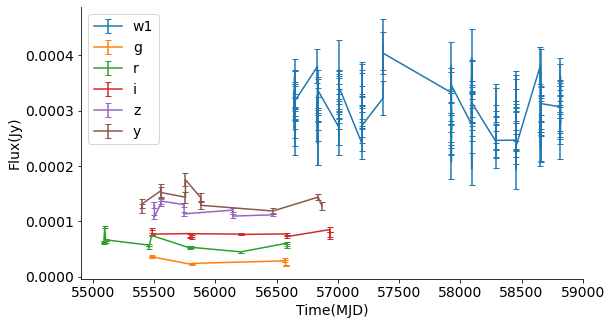

In [222]:
#data structure is called df_lc
#bands we currently have available are WISE & pan-starrs
availband = ['w1', 'g', 'r', 'i', 'z','y']
obj = 1  #pick one to look at for now
fig, ax = plt.subplots(figsize=(9,5))

for l in range(len(availband)):
    band_lc = df_lc.loc[(obj, availband[l]), :]
    band_lc.reset_index(inplace=True)
    ax.errorbar(band_lc.time, band_lc.flux, band_lc.err, capsize = 3.0, label = availband[l])
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Time(MJD)')
ax.set_ylabel('Flux(Jy)')
plt.legend()

## Image extension: look for archival images of these targets
- NASA NAVO use cases should help us to learn how to do this
- can use the cutout service now in astropy from the first fornax use case

## ML Extension 
Consider training a ML model to do light curve classification based on this sample of CLAGN
 - once we figure out which bands these are likely to be observed in, could then have a optical + IR light curve classifier
 - what would the features of the light curve be?
 - what models are reasonable to test as light curve classifiers?
 - could we make also a sample of TDEs, SNe, flaring AGN? - then train the model to distinguish between these things?
 - need a sample of non-flaring light curves
 
After training the model:
 - would then need a sample of optical + IR light curves for "all" galaxies = big data to run the model on.

Some resources to consider:
- https://github.com/dirac-institute/ZTF_Boyajian
- https://ui.adsabs.harvard.edu/abs/2022AJ....164...68S/abstract
- https://ui.adsabs.harvard.edu/abs/2019ApJ...881L...9F/abstract

